<a href="https://colab.research.google.com/github/alfan-ntu/TF_Serial_Data/blob/master/Stock_Price_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" Import Libraries """
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
""" Utilities , no more helper functions to generate synthetic data """
def plot_series(x, y, format='-', start=0, end=None, title=None,
                xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup figure dimension
    plt.figure(figsize=(5, 3))

    # Check if there are more than two series to plot
    if type(y) is tuple:
      for y_curr in y:
        # plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)

    # label the x-axis
    plt.xlabel(xlabel)

    # label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid over the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

    return

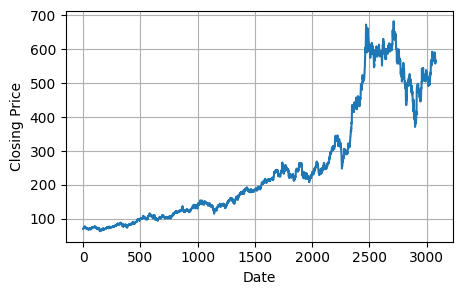

In [3]:
# Initialize lists
time_step = []
closing_price = []

# Open CSV file and read it row by row
with open('./drive/MyDrive/test_data/2330_stock_data_2011-01-01.csv') as csvfile:
  # initialize a csv file reader
  reader = csv.reader(csvfile, delimiter=',')
  # skip the first row
  next(reader)
  # iterate the remaining rows
  no_rec = 0
  for row in reader:
    # time_step.append(int(row[0]))
    closing_price.append(float(row[6]))
    no_rec += 1

  time_step = [*range(no_rec)]

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(closing_price)

# Plort the sunspots series
plot_series(time, series, xlabel='Date', ylabel='Closing Price')

In [4]:
len(time)

3080

In [5]:
""" Split the Dataset """
split_time = 2500  # total number of stock price dataset is 3080

# get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
""" Prepare Features and Labels """
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data and only take those with the specified size
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Parameters
window_size = 20
batch_size = 12
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
""" Build the Model """
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           padding='causal',
                           input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 800)
])

# Report the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [9]:
""" Tune the Learning Rate """
init_weights = model.get_weights()

In [10]:
# Trial training the model to get an optimal learning rate by arranging
# a learning rate scheduler callback first
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['accuracy'])

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
207/207 [==============================] - 21s 9ms/step - loss: 245.5411 - accuracy: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
207/207 [==============================] - 2s 8ms/step - loss: 158.0811 - accuracy: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
207/207 [==============================] - 2s 8ms/step - loss: 99.7840 - accuracy: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
207/207 [==============================] - 2s 10ms/step - loss: 74.3595 - accuracy: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
207/207 [==============================] - 2s 11ms/step - loss: 67.3337 - accuracy: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
207/207 [==============================] - 2s 8ms/step - loss: 54.9521 - accuracy: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
207/207 [==============================] - 2s 8ms/step - loss: 44.6594 - accuracy: 0.0000e+00 - lr: 1.9953e-08
Epoch 8/100
207/207 [==============================] - 2s 8ms/step - loss: 35.2241 - accuracy: 0.0000e+00 - lr: 2.2387e-08
Epoch 9/100

(1e-08, 0.001, 0.0, 500.0)

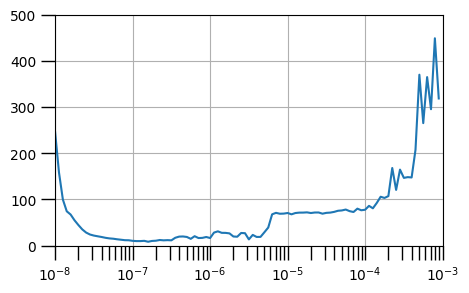

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
# Set the figure size
plt.figure(figsize=(5, 3))
# Set the grid
plt.grid(True)
# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])
# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')
# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 500])

In [12]:
"""
Retrain the model by adjusting the learning rate based on the above experiment
"""
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=100)

Epoch 1/100
207/207 [==============================] - 6s 7ms/step - loss: 94.5805 - mae: 95.0796
Epoch 2/100
207/207 [==============================] - 2s 8ms/step - loss: 41.1171 - mae: 41.6088
Epoch 3/100
207/207 [==============================] - 2s 8ms/step - loss: 19.7677 - mae: 20.2497
Epoch 4/100
207/207 [==============================] - 2s 8ms/step - loss: 16.6144 - mae: 17.0958
Epoch 5/100
207/207 [==============================] - 2s 11ms/step - loss: 15.1027 - mae: 15.5843
Epoch 6/100
207/207 [==============================] - 2s 10ms/step - loss: 13.4486 - mae: 13.9285
Epoch 7/100
207/207 [==============================] - 2s 8ms/step - loss: 12.3349 - mae: 12.8139
Epoch 8/100
207/207 [==============================] - 2s 8ms/step - loss: 12.2820 - mae: 12.7644
Epoch 9/100
207/207 [==============================] - 2s 8ms/step - loss: 10.6242 - mae: 11.1044
Epoch 10/100
207/207 [==============================] - 2s 8ms/step - loss: 8.7973 - mae: 9.2707
Epoch 11/100
207/20

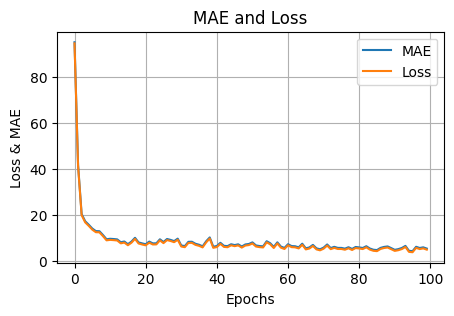

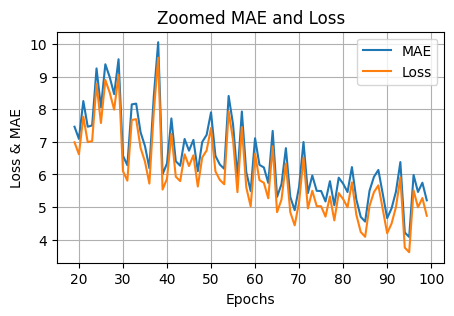

In [14]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    ylabel='Loss & MAE',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='Zoomed MAE and Loss',
    xlabel='Epochs',
    ylabel='Loss & MAE',
    legend=['MAE', 'Loss']
    )

In [43]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [16]:
# The following few cells breakdown the function model_forecast() into several different steps,
# including examing the process details
forecast_series = series[split_time-window_size+1:]

In [17]:
forecast_series.shape

(599,)

In [18]:
# Convert data list to dataset
dataset = tf.data.Dataset.from_tensor_slices(forecast_series)

In [19]:
for e in dataset.take(5):
  print(f'item of the dataset {e}, shape of element: {e.shape}')

item of the dataset 630.0, shape of element: ()
item of the dataset 627.0, shape of element: ()
item of the dataset 632.0, shape of element: ()
item of the dataset 663.0, shape of element: ()
item of the dataset 660.0, shape of element: ()


In [20]:
# Windowing the dataset into set of the same window size
dataset = dataset.window(window_size, shift=1, drop_remainder=True)

In [33]:
for d in dataset.take(1):
  print(list(d)[0])
  print(len(list(d)))

tf.Tensor(630.0, shape=(), dtype=float64)
20


In [34]:
print(f'window size: {window_size}, length of dataset: {len(dataset)}')

window size: 20, length of dataset: 580


In [35]:
# Examing the contents of windows, e.g. 5 windows
for element in dataset.take(5):
  print(f'length of element: {len(element)}')
  print([y.numpy() for y in element])

length of element: 20
[630.0, 627.0, 632.0, 663.0, 660.0, 652.0, 650.0, 641.0, 625.0, 635.0, 606.0, 609.0, 622.0, 601.0, 601.0, 598.0, 595.0, 597.0, 609.0, 614.0]
length of element: 20
[627.0, 632.0, 663.0, 660.0, 652.0, 650.0, 641.0, 625.0, 635.0, 606.0, 609.0, 622.0, 601.0, 601.0, 598.0, 595.0, 597.0, 609.0, 614.0, 611.0]
length of element: 20
[632.0, 663.0, 660.0, 652.0, 650.0, 641.0, 625.0, 635.0, 606.0, 609.0, 622.0, 601.0, 601.0, 598.0, 595.0, 597.0, 609.0, 614.0, 611.0, 613.0]
length of element: 20
[663.0, 660.0, 652.0, 650.0, 641.0, 625.0, 635.0, 606.0, 609.0, 622.0, 601.0, 601.0, 598.0, 595.0, 597.0, 609.0, 614.0, 611.0, 613.0, 604.0]
length of element: 20
[660.0, 652.0, 650.0, 641.0, 625.0, 635.0, 606.0, 609.0, 622.0, 601.0, 601.0, 598.0, 595.0, 597.0, 609.0, 614.0, 611.0, 613.0, 604.0, 602.0]


In [36]:
# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda w: w.batch(window_size))

In [37]:
# Examing the contents of a flatten window
for element in dataset.take(1):
  print(f'content of one flatten window: {element}')
  print(f'length of the flatten window: {len(element)}')
  print(f'shape of the element: {element.shape}')
  print(element.numpy()[2])


content of one flatten window: [630. 627. 632. 663. 660. 652. 650. 641. 625. 635. 606. 609. 622. 601.
 601. 598. 595. 597. 609. 614.]
length of the flatten window: 20
shape of the element: (20,)
632.0


In [38]:
n = 0
for element in dataset:
  n += 1
print(f'Total number of data elements: {n}')

Total number of data elements: 580


In [39]:
# Create batches of windows
dataset = dataset.batch(batch_size).prefetch(1)

In [40]:
n = 0
for element in dataset:
  n += 1
print(f'Total number of batches: {n}')
for element in dataset.take(1):
  print(element)
  print(f'shape of element: {element.shape}')
  print(f'value of an item in the element: {element[0]}')

Total number of batches: 49
tf.Tensor(
[[630. 627. 632. 663. 660. 652. 650. 641. 625. 635. 606. 609. 622. 601.
  601. 598. 595. 597. 609. 614.]
 [627. 632. 663. 660. 652. 650. 641. 625. 635. 606. 609. 622. 601. 601.
  598. 595. 597. 609. 614. 611.]
 [632. 663. 660. 652. 650. 641. 625. 635. 606. 609. 622. 601. 601. 598.
  595. 597. 609. 614. 611. 613.]
 [663. 660. 652. 650. 641. 625. 635. 606. 609. 622. 601. 601. 598. 595.
  597. 609. 614. 611. 613. 604.]
 [660. 652. 650. 641. 625. 635. 606. 609. 622. 601. 601. 598. 595. 597.
  609. 614. 611. 613. 604. 602.]
 [652. 650. 641. 625. 635. 606. 609. 622. 601. 601. 598. 595. 597. 609.
  614. 611. 613. 604. 602. 591.]
 [650. 641. 625. 635. 606. 609. 622. 601. 601. 598. 595. 597. 609. 614.
  611. 613. 604. 602. 591. 593.]
 [641. 625. 635. 606. 609. 622. 601. 601. 598. 595. 597. 609. 614. 611.
  613. 604. 602. 591. 593. 594.]
 [625. 635. 606. 609. 622. 601. 601. 598. 595. 597. 609. 614. 611. 613.
  604. 602. 591. 593. 594. 576.]
 [635. 606. 609.

In [41]:
forecast_series.shape

(599,)

In [44]:
#
# Calling model_forecast() to predict data of forecast_serie
#
forecast = model_forecast(model, forecast_series, window_size, batch_size)

49/49 [==============================] - 1s 7ms/step


In [45]:
forecast.shape

(580, 1)

In [47]:
results = forecast.squeeze()

In [48]:
results

array([553.78015, 552.17145, 543.0662 , 536.9625 , 534.8898 , 529.25214,
       528.8977 , 535.31964, 524.25574, 530.9527 , 538.72284, 536.9368 ,
       543.5053 , 543.6922 , 546.8482 , 552.405  , 554.3464 , 550.78955,
       546.7868 , 543.75995, 541.84235, 545.3714 , 549.6896 , 553.78516,
       551.4097 , 549.63806, 556.4112 , 562.87396, 561.1069 , 559.34827,
       560.26355, 564.4602 , 559.81854, 549.70276, 546.98395, 544.1213 ,
       543.3077 , 548.10767, 548.2603 , 531.31354, 516.84393, 508.05283,
       513.55133, 514.443  , 521.7195 , 526.6977 , 521.574  , 518.10657,
       514.6465 , 517.6678 , 520.5224 , 523.71454, 525.4822 , 528.5645 ,
       529.5576 , 524.0422 , 524.0064 , 533.8716 , 544.0231 , 555.9709 ,
       556.12634, 562.8962 , 559.759  , 561.94415, 566.01746, 565.1014 ,
       567.6321 , 552.3833 , 544.28827, 549.9597 , 550.3633 , 546.3171 ,
       544.5592 , 546.386  , 547.3039 , 546.6539 , 545.85596, 548.16205,
       551.67377, 548.3541 , 543.3069 , 536.8384 , 

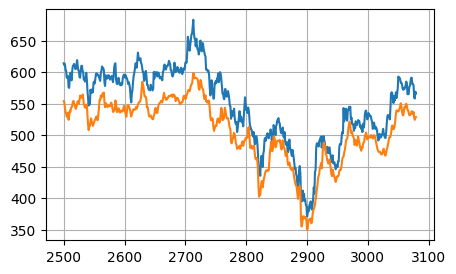

In [49]:
plot_series(time_valid, (x_valid, results))

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size+1:]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [50]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

40.73795
